# Identity Fraud From Enron Email

## 1. Goal of the Project

### Understanding the Dataset and Question

The purpose of this project is to use machine learning tools to identify Enron 
employees (Persons of Interest -POI) who have committed fraud based on the public Enron 
financial and email dataset. Enron is an energy trading company that had the largest case 
of corporate fraud in US history. POIs are one of 3: indicted, settled without admitting guilt,
or testified in exchange of immunity.

#### The Dataset

The dataset contains about 146 users (18 of them are considered POIs, while 128 are non-POIs) mostly real emails exchanged by senior management of Enron. We can use machine learning on this dataset to answer questions like "can we identify patterns in the emails?", using regression we will be able to understand the relationship between the people's salary and their bonuses for example, and using clustering we can identify who was a member of the board of directors, and who was just an employee.

The dataset has 21 features, that are either financial, email or (POI/non-POI)-related.

In [10]:
#!/usr/bin/python
import warnings; warnings.simplefilter('ignore')
import sys
import pickle
from time import time
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division


sys.path.append("../tools/")

import os
#os.chdir('C:/JBasineni/Mach_learn/ud120-projects-master/ud120-projects-master/final_project')

# Use seaborn for plotting defaults
import seaborn as sns; sns.set()

%pylab inline

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

enron_data = pickle.load(open("final_project_dataset.pkl", "rb") )
print ('Number of people in the Enron dataset: {0}'.format(len(enron_data)))




Populating the interactive namespace from numpy and matplotlib
Number of people in the Enron dataset: 146


In [11]:
nb_people=len(enron_data)
print ('Number of people in the dataset: ',nb_people)

pois = [x for x, y in enron_data.items() if y['poi']]
print ('Number of POI\'s: {0}'.format(len(pois)))
print ("Proportion of POIs in the dataset:",len(pois)/nb_people)
#nb_poi=sum([data_dict[key]['poi']==1 for key in data_dict])
#print ("Number of persons of interest (POI): ",nb_poi)
#print ("Proportion of POIs in the dataset:",nb_poi/nb_people)

Number of people in the dataset:  146
Number of POI's: 18
Proportion of POIs in the dataset: 0.1232876712328767



We observe that out of 146 persons included in the data set, only 18 persons are considered as persons of interest, which reprents 12.3%. The data set is very unbalanced.

How many features are available in the data set?

The aggregated Enron email + financial dataset is stored in a dictionary, where each key in the dictionary is a person’s name, and the value is a dictionary containing all the features of that person.

In [12]:
# No of features in the ENRON dataset
import pprint
print ('Number of features for each person in the Enron dataset: {0}'.format(len(list(enron_data.values())[0])))
print (' ')
print ('Features Available ')
#pprint.pprint(list(enron_data.values())[1] )
pprint.pprint(list(enron_data['PRENTICE JAMES'].keys()))

### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'expenses', 'total_stock_value', 'bonus', 'from_poi_to_this_person', 'shared_receipt_with_poi'] # You will need to use more features

financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
POI_label = ['poi']
total_features = POI_label + financial_features + email_features

Number of features for each person in the Enron dataset: 21
 
Features Available 
['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'email_address',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'restricted_stock',
 'director_fees']


####   Outlier investigation
Are there outliers in the data set? We can start by just exploring the data if we can identify any outliers on sight.

In [13]:
#Explore the names of the people

#pprint.pprint(list(enron_data.keys()))
pprint.pprint(enron_data['THE TRAVEL AGENCY IN THE PARK'])

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}


Clearly 'THE TRAVEL AGENCY IN THE PARK' is not a valid person and also all the values have 'NaN'. So this can be removed from out dataset. We also should remove any person who has all the values in the dataset as 'NaN'.

In [14]:
#Check for people whose total payments and total stock value is NULL
outliers =[]
for key in enron_data.keys():
    if  (enron_data[key]['total_payments']=='NaN') & (enron_data[key]['total_stock_value']=='NaN') :
        outliers.append(key)
print ("What's the name of the outlier:",(outliers))

#pprint.pprint( (enron_data['POWERS WILLIAM']))

What's the name of the outlier: ['CHAN RONNIE', 'POWERS WILLIAM', 'LOCKHART EUGENE E']


On further exploration we also found 'CHAN RONNIE', 'POWERS WILLIAM', 'LOCKHART EUGENE E' have toal payments and total stock value as NULL . They also do not have any messages to and from any POI. So I am planning to remove these from the dataset.

In [15]:
# Removing the outliers
enron_data.pop('THE TRAVEL AGENCY IN THE PARK',0)
enron_data.pop('POWERS WILLIAM',0)
enron_data.pop('LOCKHART EUGENE E',0)
enron_data.pop('CHAN RONNIE',0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': -98784,
 'director_fees': 98784,
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 32460,
 'restricted_stock_deferred': -32460,
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}


Are there any other outliers in the data set? We can start by creating a scatter plot with the salary and bonus features.

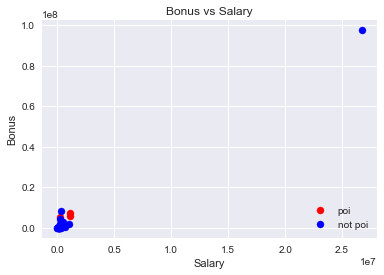

In [16]:
features_list = ["poi","salary", "bonus"]
data = featureFormat(enron_data, features_list, sort_keys = True)
poi=data[:,0]
salary = data[:,1]
bonus = data[:,2]

plt.scatter(salary[poi==1],bonus[poi==1],c='red',s=50,label='poi')
plt.scatter(salary[poi==0],bonus[poi==0],c='blue',s=50,label='not poi')

plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.legend(loc='lower right')
plt.title("Bonus vs Salary")
plt.show()


We can clearly see an outlier with a salary higher than 25,000,000 dollars and a bonus higher than 80,000,000 dollars but not a POI. But who is this outlier?

In [17]:
outliers =[]
for key in enron_data.keys():
    if (enron_data[key]['bonus']!='NaN')& (enron_data[key]['salary']!='NaN'):
        if (int(enron_data[key]['bonus'])>0.8*1e8) & (int(enron_data[key]['salary'])>2.5*1e7):
            outliers.append(key)
print ("What's the name of the outlier:",outliers)

What's the name of the outlier: ['TOTAL']


That solves the mystery. It appears that there is a bug in the data set. The outlier is in fact the total of each variable. Let's remove this outlier.

In [18]:
# We use the method pop to remove in the dictionary the item 'TOTAL.
enron_data.pop('TOTAL',0)
data = featureFormat(enron_data, features_list)

LEts try to check for Outliers again after removing the total row from dataset

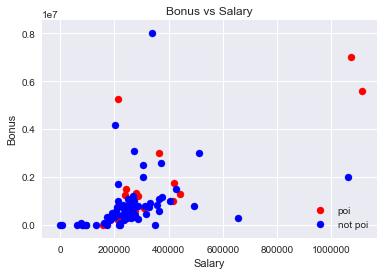

In [19]:
# Let's check for Outliers again
poi=data[:,0]
salary = data[:,1]
bonus = data[:,2]

plt.scatter(salary[poi==1],bonus[poi==1],c='red',s=50,label='poi')
plt.scatter(salary[poi==0],bonus[poi==0],c='blue',s=50,label='not poi')

plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.legend(loc='lower right')
plt.title("Bonus vs Salary")
plt.show()

Now that we have cleaned up our dataset for Outliers and data elements which do not make sense  we can move to feature selection 

## 2.Feature Selection/Engineering

### New Feature

Persons of interest may have strong email connections. POIs might send emails to other POIs at a higher rate than the rest of the population. For this reason, let's create two new features: one that represents the fraction of emails that a person sent to POIs, and another feature that represents the fraction of emails that a person received from POIs.

In [20]:
# Functions to calculate the fraction of emails from /to a person and a POI
def computeFraction(poi_messages, all_messages):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    fraction = 0.
    
    if poi_messages=='NaN' or all_messages=='NaN':
        fraction = 0.
    else:  
        fraction=float(poi_messages)/float(all_messages)

    return fraction


for name in enron_data:

    data_point = enron_data[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    data_point["fraction_to_poi"] = fraction_to_poi
features_list_n = total_features
features_list_n.remove('email_address')
features_list_n =  features_list_n + ['fraction_from_poi', 'fraction_to_poi']
#pprint.pprint (features_list_n)

In [21]:
fraction_to_poifraction =[enron_data[key]["fraction_to_poi"] for key in enron_data]
fraction_from_poi=[enron_data[key]["fraction_from_poi"] for key in enron_data]
poi=[enron_data[key]["poi"]==1 for key in enron_data]

In [22]:

def takeSecond(elem):
    """ take second element for sort
    """
    return elem[1]

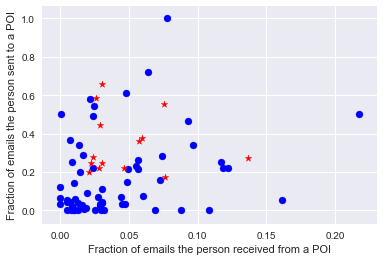

In [23]:
### create new features
### new features are: fraction_to_poi_email,fraction_from_poi_email

def dict_to_list(key,normalizer):
    new_list=[]

    for i in enron_data:
        if enron_data[i][key]=="NaN" or enron_data[i][normalizer]=="NaN":
            new_list.append(0.)
        elif enron_data[i][key]>=0:
            new_list.append(float(enron_data[i][key])/float(enron_data[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in enron_data:
    enron_data[i]["fraction_from_poi"]=fraction_from_poi[count]
    enron_data[i]["fraction_to_poi"]=fraction_to_poi[count]
    count +=1

    
features_list = ["poi", "fraction_from_poi", "fraction_to_poi"]    
    ### store to my_dataset for easy export below
my_dataset = enron_data


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    #plt.scatter( from_poi, to_poi )
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", marker="*",label='poi')
    else:
        plt.scatter(from_poi, to_poi, color="b", label='not poi')

plt.xlabel('Fraction of emails the person received from a POI') 
plt.ylabel('Fraction of emails the person sent to a POI')  
plt.show()

We can observe that these two features have a discriminating power between POI and non POI. For example, we can observe that there are no POIs with fraction_to_poi<0.2.



To select the features we will use an automated feature selection function named SelectKBest from the sklearn library. We will tune the parameter K (number of features) at the same time we tune the parameters of the machine learning algorithm during the implementation of cross-validation. If we select the number of features on the entire data set and then we tune the parameters of the machine learning algorithm there is a risk of overfitting.

In [24]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list_n, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [25]:
# intelligently select features (univariate feature selection)
import pprint
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k = 10)
selector.fit(features, labels)
scores = zip(features_list_n[1:], selector.scores_)
sorted_scores = sorted(scores, key = takeSecond, reverse = True)
#pprint.pprint('SelectKBest scores: ')
pprint.pprint( sorted_scores)
all_features =  POI_label + [(i[0]) for i in sorted_scores[0:20]]
#pprint.pprint( all_features)
kBest_features = POI_label + [(i[0]) for i in sorted_scores[0:10]]
#pprint.pprint( 'KBest')
pprint.pprint( kBest_features)

#print(my_dataset)
for emp in enron_data:
    for f in enron_data[emp]:
        if enron_data[emp][f] == 'NaN':
            # fill NaN values
            enron_data[emp][f] = 0

my_dataset = enron_data

[('exercised_stock_options', 24.25047235452619),
 ('total_stock_value', 23.613740454440887),
 ('bonus', 20.25718499812395),
 ('salary', 17.71787357924329),
 ('fraction_to_poi', 15.946248696687636),
 ('deferred_income', 11.222175285805182),
 ('long_term_incentive', 9.62221216430468),
 ('restricted_stock', 8.947938884292649),
 ('total_payments', 8.570823078730976),
 ('shared_receipt_with_poi', 8.277457991443601),
 ('loan_advances', 7.066710861319749),
 ('expenses', 5.815328001904854),
 ('from_poi_to_this_person', 5.041257378669385),
 ('other', 4.070343006434408),
 ('fraction_from_poi', 2.963990314926164),
 ('from_this_person_to_poi', 2.295183195738003),
 ('director_fees', 1.9332910310121643),
 ('to_messages', 1.5634425546665922),
 ('deferral_payments', 0.24033464535223048),
 ('from_messages', 0.18071817710224855),
 ('restricted_stock_deferred', 0.06696644496108223)]
['poi',
 'exercised_stock_options',
 'total_stock_value',
 'bonus',
 'salary',
 'fraction_to_poi',
 'deferred_income',
 'lo

#### Exploring the Precision and Accuracy with and without the new features

__Feature Scalling__


Since my selected features had different units and some of the features had very big values, I needed to transform them. I used MinMaxScaler from sklearn to scale all my selected features to a given range (between 0 and 1).


In [26]:


# dataset without new features
from sklearn import preprocessing
data = featureFormat(my_dataset, kBest_features, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

# dataset with new features
kBest_new_features = kBest_features + ['fraction_from_poi', 'fraction_to_poi']
data = featureFormat(my_dataset, kBest_new_features, sort_keys = True)
new_labels, new_features = targetFeatureSplit(data)
new_features = scaler.fit_transform(new_features)

Let's check our 2 datasets with and without the new features will the 5 algorithms and see which provides a better accuracy and precission.

In [27]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

def tune_params(grid_search, features, labels, params, iters = 80):
    """ given a grid_search and parameters list (if exist) for a specific model,
    along with features and labels list,
    it tunes the algorithm using grid search and prints out the average evaluation metrics
    results (accuracy, percision, recall) after performing the tuning for iter times,
    and the best hyperparameters for the model
    """
    acc = []
    pre = []
    recall = []
    
    for i in range(iters):
        features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size = 0.3, random_state = i)
        grid_search.fit(features_train, labels_train)
        predicts = grid_search.predict(features_test)

        acc = acc + [accuracy_score(labels_test, predicts)] 
        pre = pre + [precision_score(labels_test, predicts)]
        recall = recall + [recall_score(labels_test, predicts)]
    print ("accuracy: {}".format(np.mean(acc)))
    print ("precision: {}".format(np.mean(pre)))
    print ("recall: {}".format(np.mean(recall)))

    best_params = grid_search.best_estimator_.get_params()
    for param_name in params.keys():
        print("%s = %r, " % (param_name, best_params[param_name]))

#### 1. Naive Bayes

In [28]:
from sklearn.model_selection import GridSearchCV

# 1. Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_param = {}
nb_grid_search = GridSearchCV(estimator = nb_clf, param_grid = nb_param)
print("Naive Bayes model evaluation")
tune_params(nb_grid_search, features, labels, nb_param)
print("Naive Bayes model evaluation with new features")
tune_params(nb_grid_search, new_features, new_labels, nb_param)

Naive Bayes model evaluation
accuracy: 0.8470930232558139
precision: 0.3991815476190476
recall: 0.33036706349206346
Naive Bayes model evaluation with new features
accuracy: 0.8325581395348836
precision: 0.35005005411255413
recall: 0.31953373015873016


#### 2. Support Vector Machines

In [29]:
# 2. Support Vector Machines
from sklearn import svm
svm_clf = svm.SVC()
svm_param = {'kernel':('linear', 'rbf', 'sigmoid'),
'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
'C': [0.1, 1, 10, 100, 1000]}
svm_grid_search = GridSearchCV(estimator = svm_clf, param_grid = svm_param)

print("SVM model evaluation")
tune_params(svm_grid_search, features, labels, svm_param)
print("SVM model evaluation with New Features")
tune_params(svm_grid_search, new_features, new_labels, svm_param)

SVM model evaluation
accuracy: 0.8645348837209301
precision: 0.15124999999999997
recall: 0.06362103174603176
kernel = 'sigmoid', 
gamma = 1, 
C = 100, 
SVM model evaluation with New Features
accuracy: 0.8630813953488371
precision: 0.13458333333333333
recall: 0.06457837301587302
kernel = 'linear', 
gamma = 1, 
C = 10, 


#### 3. Decision Tree

In [30]:
# 3. Decision Tree
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier()
dt_param = {'criterion':('gini', 'entropy'),
'splitter':('best','random')}
dt_grid_search = GridSearchCV(estimator = dt_clf, param_grid = dt_param)

print("Decision Tree model evaluation")
tune_params(dt_grid_search, features, labels, dt_param)
print("Decision Tree model evaluation with New Features")
tune_params(dt_grid_search, new_features, new_labels, dt_param)

Decision Tree model evaluation
accuracy: 0.824127906976744
precision: 0.3235957792207792
recall: 0.3026984126984127
criterion = 'gini', 
splitter = 'best', 
Decision Tree model evaluation with New Features
accuracy: 0.8203488372093022
precision: 0.31769823926073926
recall: 0.3378571428571428
criterion = 'entropy', 
splitter = 'best', 


#### 4. Random Forest

In [31]:
# 4. Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=10)
rf_param = {}
rf_grid_search = GridSearchCV(estimator = rf_clf, param_grid = rf_param)

print("Random Forest model evaluation")
tune_params(rf_grid_search, features, labels, rf_param)
print("Random Forest model evaluation with New Features")
tune_params(rf_grid_search, new_features, new_labels, rf_param)

Random Forest model evaluation
accuracy: 0.8656976744186047
precision: 0.3817857142857143
recall: 0.13986111111111113
Random Forest model evaluation with New Features
accuracy: 0.8651162790697674
precision: 0.3506845238095238
recall: 0.15501488095238095


#### 5. Logistic Regression

In [32]:
# 5. Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_param = {'tol': [1, 0.1, 0.01, 0.001, 0.0001],
'C': [0.1, 0.01, 0.001, 0.0001]}
lr_grid_search = GridSearchCV(estimator = lr_clf, param_grid = lr_param)

print("Logistic Regression model evaluation")
tune_params(lr_grid_search, features, labels, lr_param)
print("Logistic Regression model evaluation with new features")
tune_params(lr_grid_search, new_features, new_labels, lr_param)

Logistic Regression model evaluation
accuracy: 0.8723837209302324
precision: 0.0
recall: 0.0
tol = 1, 
C = 0.1, 
Logistic Regression model evaluation with new features
accuracy: 0.8723837209302324
precision: 0.0
recall: 0.0
tol = 1, 
C = 0.1, 


Let us pick the dataset without new features as these did not improve the precission and recall in any of the five models we have explored .

In [33]:


# dataset without new features
from sklearn import preprocessing
data = featureFormat(my_dataset, all_features, sort_keys = True)
labels1, features1 = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features1 = scaler.fit_transform(features1)



In [34]:
from sklearn.feature_selection import SelectKBest, f_classif
def feature_selection(nb_features,features, labels):
    selector = SelectKBest(f_classif, k=nb_features)
    selector.fit(features, labels)
    return selector

## 3. Validation strategy and evluation metrics
 Implementation of cross-validation
To tune the machine learning algorithm we will use the cross-validation method. It's a great method to maximize the accuracy of the metrics we will chose to assess the performance of the algorithm. This method will also correctly tune the algorithm parameters to find the right trade-off between bias and variance in order to make sure that our algorithm is able to generalize (not overfitting).

Usually we use K-cross-validation that consists of spliting the data into K chunks and performs K fits, where each chunk gets a turn as the validation set. Here, we will use a different cross-validation method, named StratifiedShuffleSplit, because of the small size of the data set and the unbalanced labels. This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

In [35]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif

def test_classifier(clf, labels, features,nb_features, folds = 1000):
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    precision=0
    recall=0
    f1=0
    f2=0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
            
        #Selection of the best K features   
       # selector=feature_selection(nb_features,features_train, labels_train)
        selector=feature_selection(nb_features,features_train, labels_train)
        features_train_transformed = selector.transform(features_train)
        features_test_transformed  = selector.transform(features_test)   
            
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train_transformed, labels_train)
        predictions = clf.predict(features_test_transformed)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                break
   
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
    except:
        #print "Got a divide by zero when trying out:", clf
        None
    return precision,recall,f1,f2

### Evaluation metrics
To assess the performance of our algorithm we will look at two evaluation metrics:

Precision = true positives/(true positives + false positives)
Recall = true positives/(true positives + false negatives)
There’s usually a tradeoff between precision and recall. Sometimes the identifier doesn't have great precision, but it does have good recall. That means that, nearly every time a POI shows up in the test set, we are able to identify him or her. The cost of this is that we sometimes get some false positives, where non-POI get flagged.

Sometimes, instead, the identifier doesn't have a great recall, but it does have good precision. That means that whenever a POI gets flagged in the test set, we know with a lot of confidence that it's very likely to be a real POI and not a false alarm. On the other hand, the price we pay for this is that we sometimes miss real POIs, since we are reclucant to pull the trigger on edge cases.

For this project we want that precision and recall are both at least 0.3.

We will also compute the F-score that combines precision and recall. There are two versions of the F-score. The F1 score put the same weight on precision and recall, however F2 score put more wights on recall.

## 4, Choosing and tuning the algorithm

#### Gaussian Naive Bayes (GaussianNB)
For the Gaussian Naive Bayes algorithm there are no specific parameters to tune, however we need to select the number of features.

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
nb_features_orig=len(features1[1])
#print(nb_features_orig)
#For each case, we want to record the different metrics.
precision_result=[]
recall_result=[]
f1_result=[]
f2_result=[]
nb_feature_store=[]

#Classifier
clf=GaussianNB()

#We calculate the evaluation metrics for k best number of features selected in the model.
for nb_features in range(1,20):
    
    #We use cross-validation and we calculate precision and recall metrics
    precision,recall,f1,f2=test_classifier(clf, labels1, features1,nb_features, folds = 1000)
    #We record the evaluation metrics for each case               
    precision_result.append(precision)
    recall_result.append(recall)     
    f1_result.append(f1)
    f2_result.append(f2)
    nb_feature_store.append(nb_features)
    #feature_name.append(features1)

Let's plot the precision and recall by number of features selected in the model.

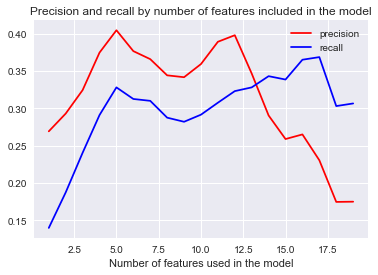

In [37]:
plt.plot(range(1,nb_features_orig),precision_result,c='red',label='precision')
plt.plot(range(1,nb_features_orig),recall_result,c='blue',label='recall')
plt.xlabel("Number of features used in the model")
plt.title("Precision and recall by number of features included in the model")
plt.legend()
plt.show()

We observe that if we select 5 best features we have the best performance with a precision and recall higher than 0.3. 
What are the exact precision and recall when we select the 5 best features?

In [38]:
print ("Precsion when the 5 best features are selected:",precision_result[4])
print ("Recall when the 5 best features are selected",recall_result[4])

Precsion when the 5 best features are selected: 0.40443896424167697
Recall when the 5 best features are selected 0.328


In [39]:
import pandas as pd
result=pd.DataFrame([nb_feature_store,precision_result,recall_result,f1_result,f2_result]).T
result.columns=['nb_feature','precision','recall','f1','f2']
result.head()

,nb_feature,precision,recall,f1,f2
0,1.0,0.269231,0.1400,0.184211,0.154867
1,2.0,0.292969,0.1875,0.228659,0.202047
2,3.0,0.324343,0.2405,0.276199,0.253612
3,4.0,0.374517,0.2910,0.327518,0.304584
4,5.0,0.404439,0.3280,0.362231,0.340885


In [40]:
#selector=feature_selection(6,features, labels)
import pandas as pd
feature_importance=pd.DataFrame([features_list_n[1:],list(selector.scores_)]).T
feature_importance.columns=['feature_name','score']
feature_importance.head()
#feature_importance.sort_values('score',ascending=False)


,feature_name,score
0,salary,17.7179
1,deferral_payments,0.240335
2,total_payments,8.57082
3,loan_advances,7.06671
4,bonus,20.2572


The 5 best features are:

salary <br />
deferral_payments <br />
total_payments <br />
loan_advances <br />
bonus 


### b. K-Nearest Neighbors
Let's try the K-Nearest Neighbors algorithm. Before training this algorithm, it's important to rescale the features because the algorithm compute the euclidian distance and it will be more affected my large features.

In [41]:

from sklearn.preprocessing import MinMaxScaler
min_max_scaler=MinMaxScaler()
features=min_max_scaler.fit_transform(features1)

One parameter which is important to tune for the k-Nearest-neighbors is the number of neighbors. If we set n_neighbors=1, the person is going to be labeled based on the closest neighbor. If we set n_neighbors=10, the person is going to labeled based on the 10 nearest neighbors. When the number of neighbors is small, the bias is low, however the variance is high. That's why it's important to find the right trade-off by using a cross-validation method to tune the parameter.

In [42]:
from sklearn.neighbors import KNeighborsClassifier

nb_features_orig=len(features1[1])

#For each case, we want to record the different metrics.
precision_result=[]
recall_result=[]
f1_result=[]
f2_result=[]

nb_neighbors_store=[]
nb_feature_store=[]

#Number of neighbours tested
nb_neighbors=[1,2,3,5,10,20,30]

#We calculate the evaluation metrics for k best number of features selected in the model.
for nb_features in range(1,nb_features_orig+1):
    #Number of neighbours
    for k in range(len(nb_neighbors)):
        
        #classifier
        clf =KNeighborsClassifier(n_neighbors=nb_neighbors[k])
        #We use cross-validation and we calculate precision and recall metrics
        precision,recall,f1,f2=test_classifier(clf, labels1, features1,nb_features, folds = 1000)
        
        #We record the evaluation metrics for each case
        precision_result.append(precision)
        recall_result.append(recall)     
        f1_result.append(f1)
        f2_result.append(f2)
        nb_feature_store.append(nb_features)
        nb_neighbors_store.append(nb_neighbors[k])


Let's create a pandas DataFrame with the avaluation metrics (precision, recall, f1,f2) for each case simulated.

In [43]:
import pandas as pd
result=pd.DataFrame([nb_feature_store,nb_neighbors_store,precision_result,recall_result,f1_result,f2_result]).T
result.columns=['nb_feature','nb_neighbors','precision','recall','f1','f2']
result.head()

,nb_feature,nb_neighbors,precision,recall,f1,f2
0,1.0,1.0,0.188815,0.1840,0.186376,0.184943
1,1.0,2.0,0.267631,0.0740,0.115942,0.086519
2,1.0,3.0,0.212963,0.1035,0.139300,0.115359
3,1.0,5.0,0.364769,0.1025,0.160031,0.119715
4,1.0,10.0,0.000000,0.0000,0.000000,0.000000


First, we want to determine how many features we want to select to have the best precision and recall.

We select the best F2-score for each number of features included in the model. We use the F2 score instead of F1 socre because it puts more weight on recall. This is important because recall tends to be lower, and we want to find precision and recall higher than 0.3.

In [44]:
result_sort_by_f2=result.sort_values('f2',ascending=False)
result_group=result_sort_by_f2.groupby('nb_feature')

In [45]:

top_param_by_nbfeature=result_group.head(1).sort_values('nb_feature')
top_param_by_nbfeature.head()

,nb_feature,nb_neighbors,precision,recall,f1,f2
0,1.0,1.0,0.188815,0.1840,0.186376,0.184943
9,2.0,3.0,0.376596,0.1770,0.240816,0.197987
14,3.0,1.0,0.293750,0.2820,0.287755,0.284274
21,4.0,1.0,0.295512,0.2930,0.294251,0.293499
28,5.0,1.0,0.207324,0.1925,0.199637,0.195293


Let's plot the precision and recall by number of features selected in the model.

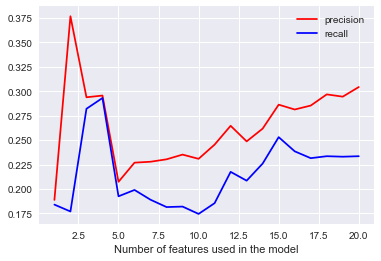

In [46]:
plt.plot(top_param_by_nbfeature.nb_feature,top_param_by_nbfeature.precision,c='red',label='precision')
plt.plot(top_param_by_nbfeature.nb_feature,top_param_by_nbfeature.recall,c='blue',label='recall')
plt.xlabel("Number of features used in the model")
plt.legend()
plt.show()

The 4 best features selected seems to provide the best performance. However the recall is lower than 0.3.

If we select the 4 best variables, what's the number of neighbors that provides the best precision and recall (f2)?

In [47]:

top_param_by_nbfeature[top_param_by_nbfeature.nb_feature==4]

,nb_feature,nb_neighbors,precision,recall,f1,f2
21,4.0,1.0,0.295512,0.293,0.294251,0.293499


### Decission Tree Classifier
Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression

For the Decission Tree Classifier algorithm, we need to tune the following parameters:

__criterion__: It defines the function to measure the quality of a split. Sklearn supports “gini” 
criteria for Gini Index & “entropy” for Information Gain. By default, it takes “gini” value.<br />
__splitter__: It defines the strategy to choose the split at each node. Supports “best” value to choose the best split & “random” to choose the best random split. By default, it takes “best” value.<br />
__max_features__: It defines the no. of features to consider when looking for the best split. We can input integer, float, string & None value


In [48]:
from sklearn import tree

nb_features_orig=len(features1[1])

#For each case, we want to record the different metrics.
precision_result=[]
recall_result=[]
f1_result=[]
f2_result=[]
nb_feature_store=[]


#Param

#dt_clf = tree.DecisionTreeClassifier()
dt_param = {'criterion':('gini', 'entropy'),
'splitter':('best','random')}
#clf = GridSearchCV(estimator = dt_clf, param_grid = dt_param)



#We calculate the evaluation metrics for k best number of features selected in the model.
for nb_features in range(1,nb_features_orig+1):
    #Number of neighbours
           
        #classifier
        clf = tree.DecisionTreeClassifier()
        #We use cross-validation and we calculate precision and recall metrics
        precision,recall,f1,f2=test_classifier(clf, labels1, features1,nb_features, folds = 1000)
        
        #We record the evaluation metrics for each case
        precision_result.append(precision)
        recall_result.append(recall)     
        f1_result.append(f1)
        f2_result.append(f2)
        nb_feature_store.append(nb_features)




Let's create a pandas DataFrame with the avaluation metrics (precision, recall, f1,f2) for each case simulated.

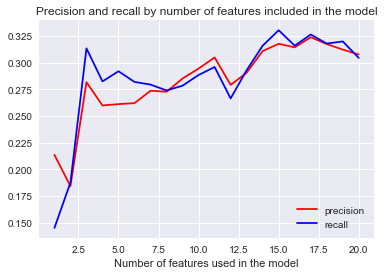

In [49]:
plt.plot(nb_feature_store,precision_result,c='red',label='precision')
plt.plot(nb_feature_store,recall_result,c='blue',label='recall')
plt.xlabel("Number of features used in the model")
plt.title("Precision and recall by number of features included in the model")
plt.legend()
plt.show()

In [50]:
import pandas as pd
result=pd.DataFrame([nb_feature_store,precision_result,recall_result,f1_result,f2_result]).T
result.columns=['nb_feature','precision','recall','f1','f2']
result.head()

,nb_feature,precision,recall,f1,f2
0,1.0,0.213549,0.1450,0.172722,0.154948
1,2.0,0.184185,0.1875,0.185828,0.186827
2,3.0,0.281798,0.3135,0.296805,0.306601
3,4.0,0.259890,0.2825,0.270724,0.277669
4,5.0,0.261181,0.2920,0.275732,0.285268


First, we want to determine how many features we want to select to have the best precision and recall.

We select the best F2-score for each number of features included in the model. We use the F2 score instead of F1 socre because it puts more weight on recall which is important because recall tends to be lower and we want to find precision and recall higher than 0.3.

In [51]:
result_sort_by_f2=result.sort_values('f2',ascending=False)
#result_group=result_sort_by_f2.groupby('nb_feature')
result_sort_by_f2.head(10)

,nb_feature,precision,recall,f1,f2
14,15.0,0.317788,0.3305,0.324020,0.327877
16,17.0,0.323909,0.3265,0.325199,0.325978
18,19.0,0.312347,0.3200,0.316127,0.318440
17,18.0,0.317524,0.3180,0.317762,0.317905
15,16.0,0.314428,0.3160,0.315212,0.315684
13,14.0,0.311024,0.3160,0.313492,0.314992
2,3.0,0.281798,0.3135,0.296805,0.306601
19,20.0,0.307731,0.3045,0.306107,0.305141
10,11.0,0.304997,0.2960,0.300431,0.297757
12,13.0,0.290675,0.2930,0.291833,0.292532


As it was evident from the plot and the F2 values picking 17 best features gives the maximum Precission and Recall. This will create an over complex tree. But this algorithm does take longer than Naive Bayes . 

## 5. Conclusion
The goal of this project was to achieve a precision and recall higher than 0.3. From the above analysis Naive Bayes and the Decission Tree Classifier both have a precission and recall above 0.3 but Naive bayes is faster and gave the best precission and recall with less no of features which makes it less complicated.  That's why we will use Gaussian Naive Bayes algorithm to identify persons of interest. We will include in the model the 5 following features:

salary <br />
deferral_payments <br />
total_payments <br />
loan_advances <br />
bonus 


## 6. Udacity Tester

   Lets produce the (my_dataset.pkl, my_classifier.pkl, my_feature_list.pkl) files for the Udacity tester

In [52]:
data_dict = pickle.load(open("final_project_dataset.pkl", "rb") )

#We remove the outlier 'TOTAL'.
data_dict.pop('TOTAL',0)

#We create the feature 'fraction_from_poi' and 'fraction_to_poi'.
def computeFraction(poi_messages, all_messages):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    fraction = 0.
    
    if poi_messages=='NaN' or all_messages=='NaN':
        fraction = 0.
    else:  
        fraction=float(poi_messages)/float(all_messages)

    return fraction





for name in data_dict:

    data_point = data_dict[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    data_point["fraction_to_poi"] = fraction_to_poi

#We select the features
features_list = ["poi","salary", "deferral_payments","total_payments","loan_advances","bonus","restricted_stock_deferred"]

my_dataset=data_dict
data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

#We select the classifier, Gaussian Naive Bayes.
clf=GaussianNB()

#We train the classifier.
clf.fit(data,labels)



GaussianNB(priors=None)

In [53]:
sys.path.append("../final_project/")
from tester import load_classifier_and_data,test_classifier
dump_classifier_and_data(clf, my_dataset, features_list)


#pickle.dump( clf, open("my_classifier.pkl", "wb") )

### References
[1] https://www.programiz.com/python-programming/methods/built-in/sorted<br/>
[2] https://datascience.stackexchange.com/questions/10773/how-does-selectkbest-work<br/>
[3] http://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/<br/>
[4] http://scikit-learn.org/stable/supervised_learning.html<br/>
[5] https://en.wikipedia.org/wiki/Cross-validation_(statistics)<br/>
[6] https://github.com/jasminej90/dand5-identity-fraud-from-enron-email